In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.font_manager as font_manager
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy.constants as c
from matplotlib import rcParams
import matplotlib.image as mpimg
from scipy import optimize
import os


In [2]:
#define the position of the west, transit, secondary and east images to go at the top of the broadband phase curve plot
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

def get_flag(name):
    path = "{}.jpg".format(name.title())
    im = plt.imread(path)
    return im

def offset_image(coord, name, ax):
    img = get_flag(name)
    im = OffsetImage(img, zoom=0.05)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 35),  xybox=(0., 30.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0.5)

    ax.add_artist(ab)
    
def offset_image2(coord, name, ax):
    img = get_flag(name)
    im = OffsetImage(img, zoom=0.05)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 34.25),  xybox=(0., 30.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0.5)

    ax.add_artist(ab)

In [3]:
def phasecurve(shortname, folder, title):
    update = True        # Flag if we want to update the PSG/GlobES simulations or simply read/plot the spectra
    phase1 = 0        # Initial phase (degrees) for the simulation, 0 is sub-solar point, 180 is night-side
    phase2 = 360       # Final phase (degrees)
    dphase = 5        # Phase step (degrees)
    phases =[]
    nphase = int(360/dphase + 1)
    binning= 5         # Binning applied to the GCM data for each radiative-transfer (greater is faster, minimum is 1)
    lam1   = 5         # Initial wavelength of the simulations (um)
    lam2   = 21        # Final wavelength of the simulations (um)
    lamRP  = 100       # Resolving power
    radunit= 'ppm'       # Desired radiation unit (https://psg.gsfc.nasa.gov/helpmodel.php#units)
    #psgurl = 'http://localhost:3000' # URL of the PSG server - For PSG/Docker
    #psgurl = 'http://localhost' # URL of the test PSG server
    psgurl = 'https://psg.gsfc.nasa.gov' # URL of the PSG server
    string = folder+'/'+shortname+'.dat'
    print(string)
    data = np.array([])
    avg = np.zeros(nphase)
    
    # GlobES/API calls can be sequentially, and PSG will remember the previous values
    # This means that we can upload parameters step-by-step. To reset your config for GlobES (use type=set), and to simply update (use type=upd)
    if update: os.system('/usr/bin/curl -s -d app=globes -d type=set --data-urlencode file@%s %s/api.php' % (string,psgurl))
    
    # Define parameters of this run
    fr = open("config.txt", "w")
    fr.write('<GENERATOR-RANGE1>%f\n' % lam1)
    fr.write('<GENERATOR-RANGE2>%f\n' % lam2)
    fr.write('<GENERATOR-GCM-BINNING>%d' % binning)
    fr.close()
    if update: os.system('/usr/bin/curl -s -d app=globes -d type=upd --data-urlencode file@config.txt %s/api.php' % psgurl)
    
    fig, ax = plt.subplots(1,2,figsize=(25,6))
    plt.subplots_adjust(wspace = 0.15, left=0.1,right=0.9, top=1)
    # Calculate the spectra across the phases
    for phasei in range(0,nphase):
        phase = dphase*phasei
    
        if phase == 180: phase=182
        phases = phases + [phase]
        #print('phase,phases',phase,phases)
        fr = open("config.txt", "w")
        fr.write('<OBJECT-SEASON>%f\n' % phase)
        fr.write('<OBJECT-OBS-LONGITUDE>%f\n' % phase)
        fr.close()
        
        if update: os.system('/usr/bin/curl -s  -d app=globes --data-urlencode file@config.txt %s/api.php > %s/phase%d.txt' % (psgurl,folder,phase))
        print('%s/phase%d.txt' % (folder,phase))
        

        wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
        dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
        if data.size == 0:
            sz = np.shape(dat)                
            data = np.zeros((nphase,sz[0]),dtype=float)
        data[phasei,:] = total
        waverange = np.where([lam1 < i < lam2 for i in wave])[0]
        avg[phasei] = np.mean(total[waverange])
        
        rcParams['font.family'] = 'serif'
        font = font_manager.FontProperties(family='sans-serif',size=15)
        if phase == 182: # intentionally wrong
            ax[0].plot(wave,data[phasei],color='w',zorder=75,lw=1)
        else:
            colors = plt.cm.terrain_r(np.linspace(0.1,0.9,nphase))
            ax[0].plot(wave,data[phasei],color=colors[phasei],lw=1)

        #cb1.set_label('Some Units')
        #ax[0].set_yscale('log')
        #ax[0].set_xscale('log')
        ax[0].set_ylim(1e-4,50)
        ax[0].set_title(title, size=23)
        ax[0].set_xlabel('Wavelength ($\mathrm{\mu}$m)',size=23)
        ax[0].tick_params(direction='in',axis='both', which='major', labelsize=20)
        ax[0].set_ylabel('Contrast (ppm)',size=23)
        
        ax[1].set_xlim(0,360)
        ax[1].set_ylim(0.5,100)
        ticks = [0, 90, 180, 270, 360]
        ax[1].set_xticks(ticks)
        ax[1].set_xticklabels([0, 90, 180, 270, 360])
        ax[1].set_title(title, size=23,pad=60)
        ax[1].set_xlabel('Phase',size=23)
        ax[1].set_ylabel('Contrast (ppm)',size=23)
        ax[1].scatter(phase,avg[phasei],color='navy',marker='|')
        ax[1].tick_params(direction='in',axis='both', which='major', labelsize=20)
        
    ax[1].text(s='15 $-$ 21 ($\mathrm{\mu}$m)', x=282, y=40, fontsize=20, fontweight='ultralight')
    ax[1].plot(phases,avg,color='k',lw=2)
    ax[1].text(3, 0.70, '                                          ', style='italic', bbox = {'facecolor': 'white','edgecolor' :'white'},zorder=5)
        
    newcmp = ListedColormap(colors)
    cmap = plt.cm.terrain_r
    psm = plt.pcolormesh([phases], cmap=cmap, vmin=0, vmax=360, alpha=1)
    
    cbar = plt.colorbar(psm, ax=ax[0],pad=0.01)
    cbar.set_label("Phase", size=23)
    cbar.ax.tick_params(labelsize=16) 
    
    countries = ["secondary", "east", "transit", "west", "secondary"]
    enum = [(0,"secondary"),(18, "east"),(37, "transit"),(55,"west"),(73,"secondary")]
    ax2 = ax[1].twiny()
    ax2.set_xticks([0,18,37,55,73])
    ax2.set_xticklabels(countries)
    
    for i, c in enum:
        offset_image(i, c, ax2)
    plt.savefig(folder+'/'+shortname+'_nonlog.pdf',bbox_inches = "tight")
       

psg_data/01_Control_ANN5000_psg.dat
psg_data/phase0.txt
psg_data/phase5.txt
psg_data/phase10.txt
psg_data/phase15.txt
psg_data/phase20.txt
psg_data/phase25.txt
psg_data/phase30.txt
psg_data/phase35.txt
psg_data/phase40.txt
psg_data/phase45.txt


C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase0.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase0.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase5.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\App

psg_data/phase50.txt
psg_data/phase55.txt
psg_data/phase60.txt
psg_data/phase65.txt
psg_data/phase70.txt
psg_data/phase75.txt
psg_data/phase80.txt
psg_data/phase85.txt
psg_data/phase90.txt
psg_data/phase95.txt
psg_data/phase100.txt
psg_data/phase105.txt
psg_data/phase110.txt
psg_data/phase115.txt


C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase65.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase65.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase70.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase70.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg

psg_data/phase120.txt
psg_data/phase125.txt
psg_data/phase130.txt
psg_data/phase135.txt
psg_data/phase140.txt
psg_data/phase145.txt
psg_data/phase150.txt
psg_data/phase155.txt
psg_data/phase160.txt
psg_data/phase165.txt
psg_data/phase170.txt
psg_data/phase175.txt
psg_data/phase182.txt
psg_data/phase185.txt


C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase140.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase140.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase145.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase145.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: 

psg_data/phase190.txt
psg_data/phase195.txt
psg_data/phase200.txt
psg_data/phase205.txt
psg_data/phase210.txt
psg_data/phase215.txt
psg_data/phase220.txt
psg_data/phase225.txt
psg_data/phase230.txt
psg_data/phase235.txt
psg_data/phase240.txt
psg_data/phase245.txt


C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase210.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase210.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase215.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase215.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: 

psg_data/phase250.txt
psg_data/phase255.txt
psg_data/phase260.txt
psg_data/phase265.txt
psg_data/phase270.txt
psg_data/phase275.txt
psg_data/phase280.txt
psg_data/phase285.txt
psg_data/phase290.txt
psg_data/phase295.txt
psg_data/phase300.txt
psg_data/phase305.txt
psg_data/phase310.txt
psg_data/phase315.txt


C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase275.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase275.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase280.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase280.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: 

psg_data/phase320.txt
psg_data/phase325.txt
psg_data/phase330.txt
psg_data/phase335.txt
psg_data/phase340.txt
psg_data/phase345.txt
psg_data/phase350.txt
psg_data/phase355.txt
psg_data/phase360.txt


C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase345.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase345.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: "psg_data/phase350.txt"
  wave, total = np.loadtxt('%s/phase%d.txt' % (folder,phase), skiprows=14,unpack=True,usecols=(0,1))
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:52: UserWarning: loadtxt: input contained no data: "psg_data/phase350.txt"
  dat = np.loadtxt('%s/phase%d.txt' % (folder,phase),skiprows=14)
C:\Users\molly\AppData\Local\Temp\ipykernel_19260\245687780.py:51: UserWarning: loadtxt: input contained no data: 

FileNotFoundError: [Errno 2] No such file or directory: 'Secondary.jpg'

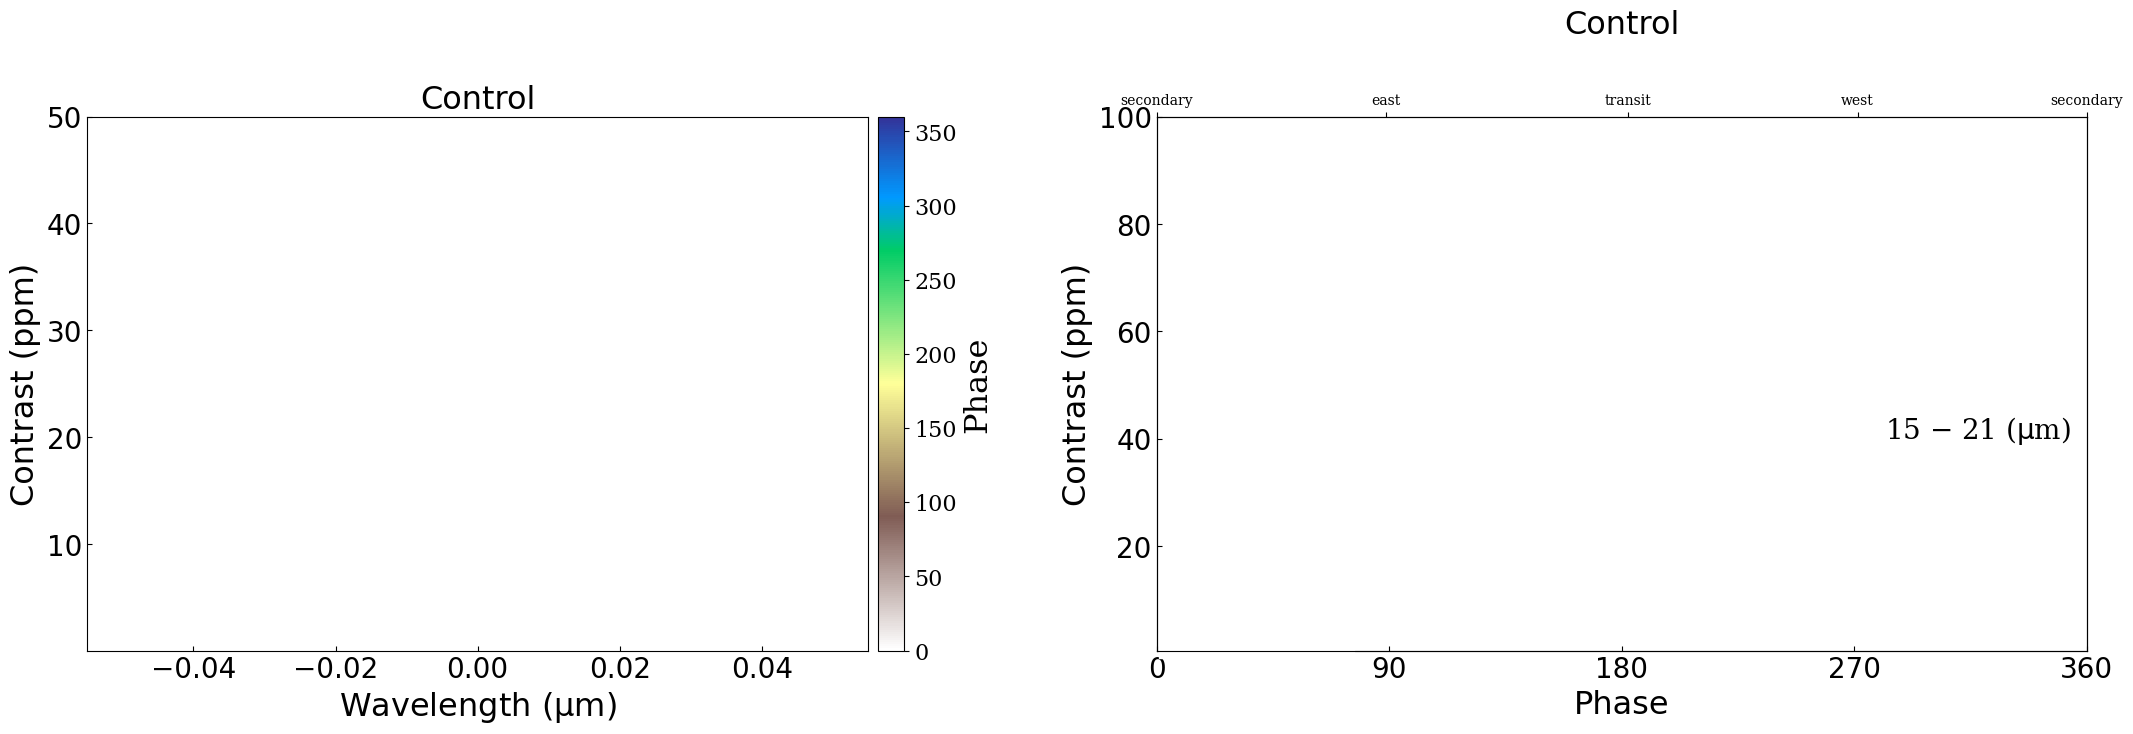

In [4]:
phasecurve('01_Control_ANN5000_psg', 'psg_data', 'Control')